<a href="https://colab.research.google.com/github/shahpriyanka26/shahpriyanka26/blob/main/TS_Neuralprophet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import itertools
from datetime import timedelta
from sklearn.metrics import mean_squared_error


In [2]:
!pip install neuralprophet[live] --quiet
from neuralprophet import NeuralProphet
from neuralprophet import set_random_seed
set_random_seed(0)

#Dataset: https://www.kaggle.com/datasets/aramacus/electricity-demand-in-victoria-australia?resource=download

The dataset covers 2016 days between 1 January 2015 and 6 October 2020. During some intraday intervals RRP was negative, so that energy producers were paying consumers rather than wise versa. Below is a brief description fo the data:

date : datetime, the date of the recording
demand : float, a total daily electricity demand in MWh
RRP : float, a recommended retail price in AUD$ / MWh
demand_pos_RRP : float, a total daily demand at positive RRP in MWh
RRP_positive : float, an averaged positive RRP, weighted by the corresponding intraday demand in AUD$ / MWh
demand_neg_RRP : float, an total daily demand at negative RRP in MWh
RRP_negative : float, an average negative RRP, weighted by the corresponding intraday demand in AUD$ / MWh
frac_at_neg_RRP : float, a fraction of the day when the demand was traded at negative RRP
min_temperature : float, minimum temperature during the day in Celsius
max_temperature : float, maximum temperature during the day in Celsius
solar_exposure : float, total daily sunlight energy in MJ/m^2
rainfall : float, daily rainfall in mm
school_day : boolean, if students were at school on that day
holiday : boolean, if the day was a state or national holiday

In [3]:
fpath = "/content/energy_demand_complete_dataset.csv"

df = pd.read_csv(fpath)
demand_df = df[['date','demand']].rename(columns={"date": "ds", "demand": "y"})
demand_df['ds'] = pd.to_datetime(demand_df['ds'])


In [4]:
demand_df.head(3)

,ds,y
0,2015-01-01,99635.03
1,2015-01-02,129606.01
2,2015-01-03,142300.54


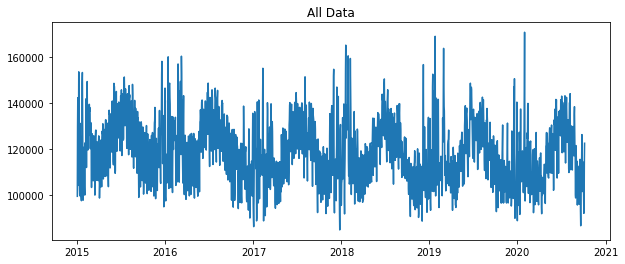

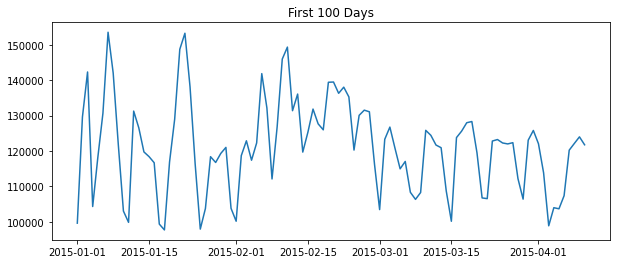

In [5]:
plt.figure(figsize=(10, 4))
plt.title("All Data")
plt.plot(demand_df['ds'].dt.to_pydatetime(), demand_df['y'])
plt.show()

plt.figure(figsize=(10, 4))
plt.title("First 100 Days")
plt.plot(demand_df['ds'].dt.to_pydatetime()[:100], demand_df['y'][:100])
plt.show()

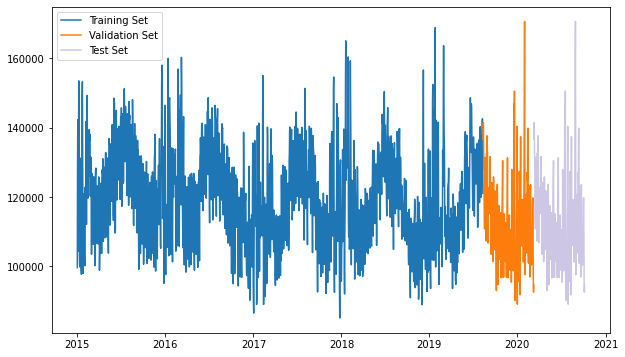

In [6]:
train_size = 0.8


df_train, df_valid = demand_df[:int(len(demand_df)*0.8)], demand_df[int(len(demand_df)*0.8):]
df_valid, df_test = df_valid[:len(df_valid)//2], df_valid[len(df_valid)//2:]

def train_valid_plot():
    """Visualizing the training + validation sets"""
    fig = plt.figure(figsize=(10,6))
    ax = fig.add_subplot(111)
    ax.plot(df_train['ds'].dt.to_pydatetime(), df_train["y"], color='#1f76b4', label='Training Set')
    ax.plot(df_valid['ds'].dt.to_pydatetime(), df_valid["y"], color='#fc7d0b', label='Validation Set')
    ax.plot(df_test['ds'].dt.to_pydatetime(), df_valid["y"], color='#CDC7E5', label='Test Set')
    ax.legend()
    plt.show()
    
train_valid_plot()

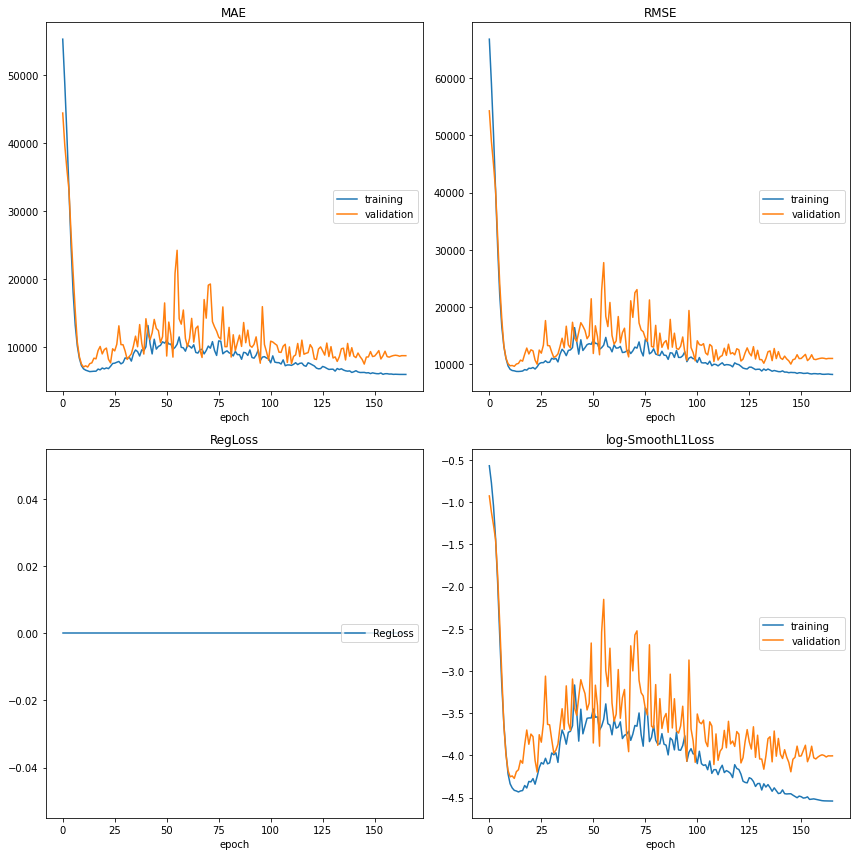

MAE
	training         	 (min: 5932.052, max: 55354.412, cur: 5932.052)
	validation       	 (min: 7022.706, max: 44464.730, cur: 8695.734)
RMSE
	training         	 (min: 8184.474, max: 66821.673, cur: 8184.474)
	validation       	 (min: 9608.028, max: 54284.945, cur: 10979.633)
RegLoss
	RegLoss          	 (min:    0.000, max:    0.000, cur:    0.000)
log-SmoothL1Loss
	training         	 (min:   -4.541, max:   -0.569, cur:   -4.541)
	validation       	 (min:   -4.273, max:   -0.927, cur:   -4.006)


,SmoothL1Loss,MAE,RMSE,RegLoss,SmoothL1Loss_val,MAE_val,RMSE_val
165,0.010664,5932.051561,8184.473519,0.0,0.018212,8695.734375,10979.632812


In [7]:
m = NeuralProphet()

m.add_country_holidays(country_name='Australia')
metrics = m.fit(df=df_train, validation_df=df_valid, freq="D", progress="plot-all")
metrics[-1:]

Looking at the metric plots above, we can see that the optimal parameters are reached around 25–30 epochs and then the model starts to overfit. We can combat this by specifying a number of epochs. A complete list of tuneable model parameters can be found here.

In [8]:
m = NeuralProphet(epochs=30)
m.add_country_holidays(country_name='Australia')
metrics2 = m.fit(df=df_train, validation_df=df_valid, freq="D")

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.941% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 32


  0%|          | 0/131 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 1.05E-01, min: 1.35E+00


  0%|          | 0/131 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 1.05E-01, min: 1.35E+00
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 1.04E-01
Epoch[30/30]: 100%|██████████| 30/30 [00:06<00:00,  4.90it/s, SmoothL1Loss=0.0107, MAE=5.94e+3, RMSE=8.26e+3, RegLoss=0, MAE_val=8.46e+3, RMSE_val=1.08e+4, SmoothL1Loss_val=0.0175]


By specifying the number of epochs, we significantly reduce the validation RMSE. 

**Model Evaluation**

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.941% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.947% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.947% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


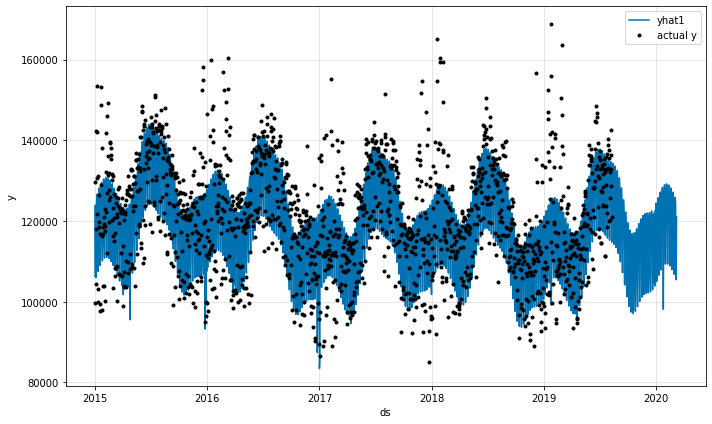

In [9]:
future = m.make_future_dataframe(df=df_train, periods=len(df_valid), n_historic_predictions=True)
forecast = m.predict(df=future)
fig_forecast = m.plot(forecast)

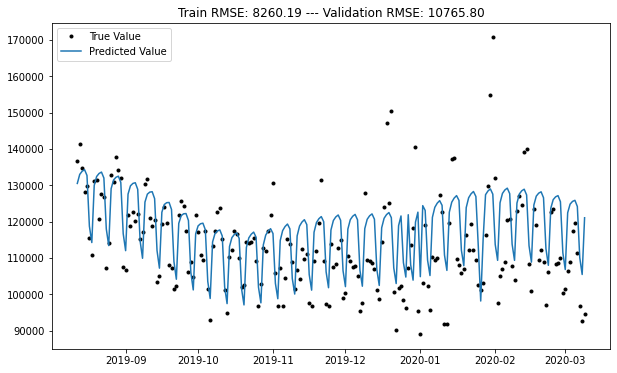

In [10]:
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111)
ax.set_title("Train RMSE: {:.2f} --- Validation RMSE: {:.2f}".format(metrics2[-1:].RMSE.values[0], metrics2[-1:].RMSE_val.values[0]))
ax.plot(df_valid['ds'].dt.to_pydatetime(), df_valid["y"],'.k', label='True Value')
ax.plot(forecast[-len(df_valid):]['ds'].dt.to_pydatetime(), forecast[-len(df_valid):]["yhat1"], label='Predicted Value')
ax.legend()
plt.show()

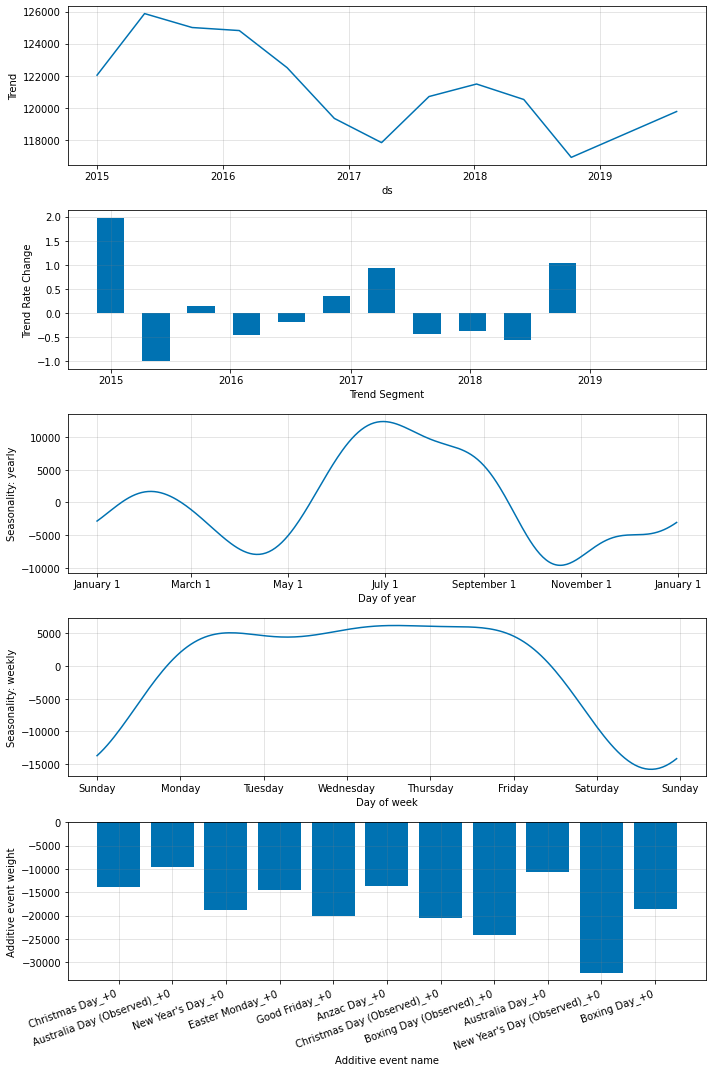

In [11]:
# fig_comp = m.plot_components(forecast) # Alternative: shows a slightly different figure
fig_param = m.plot_parameters()

 **Adding AR-Net (AutoRegression)
One of the new additions in Prophet is AR-Net (Auto-Regressive Neural Network). This allows NeuralProphet to use observations from previous time steps when making a prediction.**

AR-Net can be enabled by setting an appropriate value to the n_lags parameter when creating the NeuralProphet Model. We are also increasing the checkpoints_range as we are making short-term predictions on the data.

In [12]:

m = NeuralProphet(n_forecasts=1, n_lags=3, epochs=30, changepoints_range=0.95)
m.add_country_holidays(country_name='Australia')
metrics3 = m.fit(df=df_train, validation_df=df_valid, freq="D")

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.941% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 32


  0%|          | 0/131 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 1.70E-01, min: 3.00E+00


  0%|          | 0/131 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 1.70E-01, min: 7.14E-01
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 1.43E-01
Epoch[30/30]: 100%|██████████| 30/30 [00:04<00:00,  7.28it/s, SmoothL1Loss=0.00616, MAE=4.47e+3, RMSE=6.26e+3, RegLoss=0, MAE_val=6.12e+3, RMSE_val=8.63e+3, SmoothL1Loss_val=0.0112]


AR-net on validation set

In [13]:
valid_preds = [] #list to store predictions
lags = 3

for d in df_valid['ds'].values:
    # getting necessary df rows
    date_index = demand_df.index[demand_df['ds'] == d][0]
    future = demand_df.iloc[date_index-lags:date_index]
    
    # adding new row
    entry = pd.DataFrame({
        'ds': [d],
        'y' : [np.nan]
    })
    future = pd.concat([future, entry], ignore_index = True, axis = 0)
    
    # making prediction
    forecast = m.predict(df=future)
    valid_preds.append(forecast.loc[lags]['yhat1'])

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 75.0% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 75.0% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 75.0% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 75.0% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 75.0% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 75.0% of the data

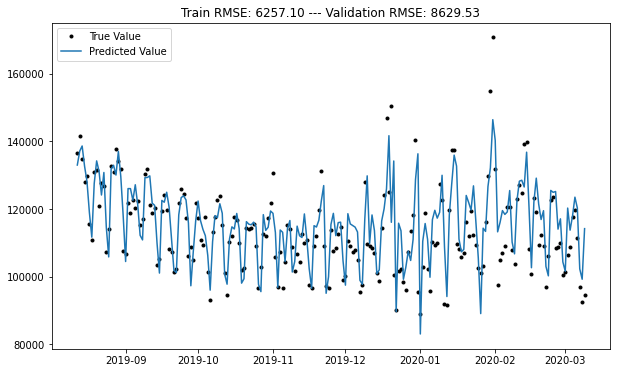

In [14]:

# Creating DF for predictions
df_valid_copy = df_valid.copy()
df_valid_copy['yhat1'] = valid_preds
df_valid_copy.head()

# Plotting Predictions
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111)
ax.set_title("Train RMSE: {:.2f} --- Validation RMSE: {:.2f}".format(metrics3[-1:].RMSE.values[0], metrics3[-1:].RMSE_val.values[0]))
ax.plot(df_valid_copy['ds'].dt.to_pydatetime(), df_valid_copy["y"],'.k', label='True Value')
ax.plot(df_valid_copy['ds'].dt.to_pydatetime(), df_valid_copy["yhat1"], label='Predicted Value')
ax.legend()
plt.show()

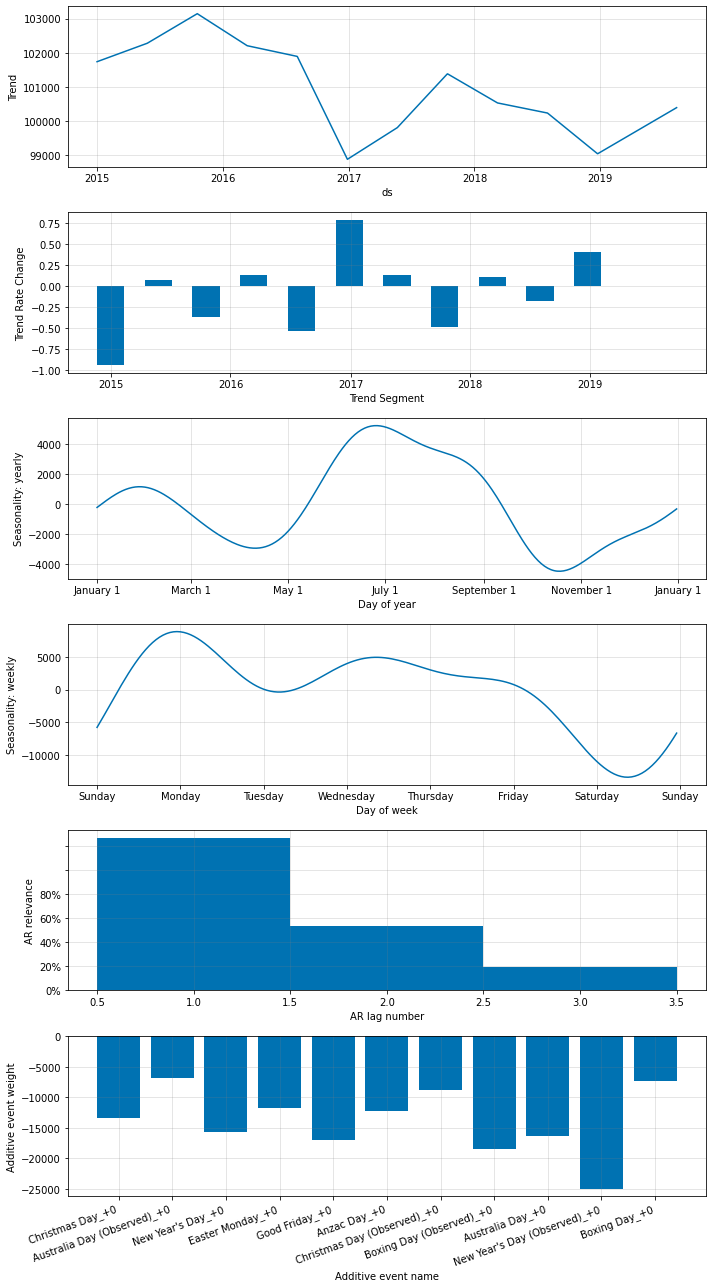

In [15]:
fig_param = m.plot_parameters()

**Hyperparameter tuning**

In [16]:
# Parameter Options
param_grid = {  
    'num_hidden_layers': [1,2],
    'changepoints_range': [0.95, 0.975, 0.99, 0.995, 0.999],
}

# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
results = []  # Store the RMSEs for each params here

# Use cross validation to evaluate all parameters
for params in all_params:
    m = NeuralProphet(**params, n_forecasts=1, newer_samples_weight=4, n_lags=3, learning_rate=0.02, epochs=50, batch_size=32)
    m.add_country_holidays(country_name='Australia')
    metrics4 = m.fit(df=df_train, validation_df=df_valid, freq="D")
    results.append(dict({"RMSE_val": metrics4['RMSE_val'].min(), "RMSE_train": metrics4['RMSE'][metrics4['RMSE_val'].idxmin()], "score_epoch_number": metrics4['RMSE_val'].idxmin()}, **params))

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.941% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
Epoch[50/50]: 100%|██████████| 50/50 [00:07<00:00,  6.88it/s, SmoothL1Loss=0.00614, MAE=4.47e+3, RMSE=6.24e+3, RegLoss=0, MAE_val=5.75e+3, RMSE_val=8.37e+3, SmoothL1Loss_val=0.0106]
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.941% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralPr

In the following cell we are re-entering high scoring model parameters that worked well.

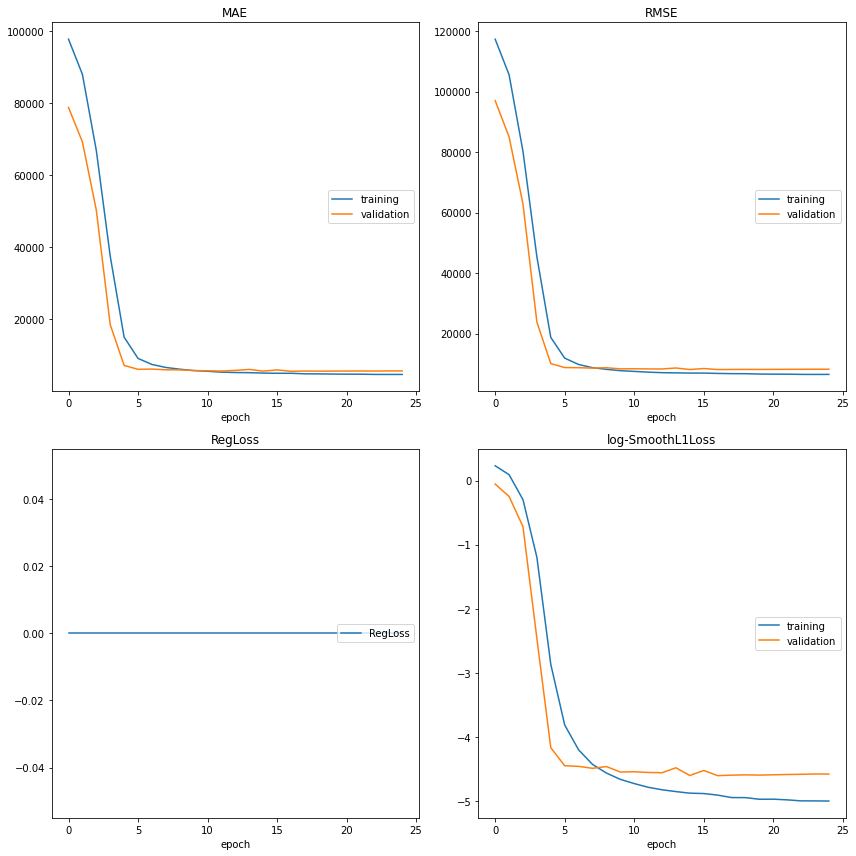

MAE
	training         	 (min: 4720.166, max: 97669.668, cur: 4720.166)
	validation       	 (min: 5597.984, max: 78738.164, cur: 5683.729)
RMSE
	training         	 (min: 6509.915, max: 117330.951, cur: 6523.984)
	validation       	 (min: 8122.580, max: 97000.000, cur: 8225.203)
RegLoss
	RegLoss          	 (min:    0.000, max:    0.000, cur:    0.000)
log-SmoothL1Loss
	training         	 (min:   -5.005, max:    0.233, cur:   -5.005)
	validation       	 (min:   -4.608, max:   -0.053, cur:   -4.583)


In [17]:

m = NeuralProphet(newer_samples_weight=5, n_forecasts=1, n_lags=3, learning_rate=0.02, epochs=25, batch_size=32, num_hidden_layers=1, changepoints_range=0.995)
m.add_country_holidays(country_name='Australia')
metrics5 = m.fit(df=df_train, validation_df=df_valid, freq="D", progress="plot-all")

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 75.0% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 75.0% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 75.0% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 75.0% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 75.0% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 75.0% of the data

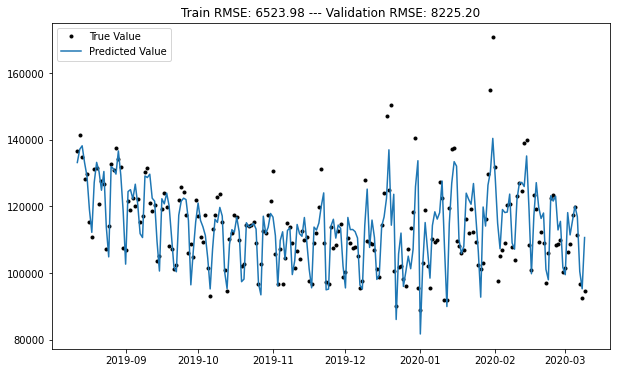

In [18]:
valid_preds = [] #list to store predictions
lags = 3

for d in df_valid['ds'].values:
    # getting necessary df rows
    date_index = demand_df.index[demand_df['ds'] == d][0]
    future = demand_df.iloc[date_index-lags:date_index]
    
    # adding new row
    entry = pd.DataFrame({
        'ds': [d],
        'y' : [np.nan]
    })
    future = pd.concat([future, entry], ignore_index = True, axis = 0)
    
    # making prediction
    forecast = m.predict(df=future)
    valid_preds.append(forecast.loc[lags]['yhat1'])
    
# Creating DF for predictions
df_valid_copy = df_valid.copy()
df_valid_copy['yhat1'] = valid_preds
df_valid_copy.head()

# Plotting Predictions
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111)
ax.set_title("Train RMSE: {:.2f} --- Validation RMSE: {:.2f}".format(metrics5[-1:].RMSE.values[0], metrics5[-1:].RMSE_val.values[0]))
ax.plot(df_valid_copy['ds'].dt.to_pydatetime(), df_valid_copy["y"],'.k', label='True Value')
ax.plot(df_valid_copy['ds'].dt.to_pydatetime(), df_valid_copy["yhat1"], label='Predicted Value')
ax.legend()
plt.show()

**Other models**

In [19]:

# Last Value Method
last_val_df = demand_df.copy()

last_val_df['y_prev'] = last_val_df['y'].shift(1)
last_val_df = last_val_df[last_val_df['ds'].isin(df_test['ds'].values)]
last_val_preds = last_val_df['y'].values

last_val_rmse = mean_squared_error(last_val_preds, last_val_df['y_prev'], squared=False)

In [20]:
!pip install statsmodels==0.12.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [21]:
# Exponential Smoothing Method
from statsmodels.tsa.api import SimpleExpSmoothing

exp_smooth_preds = []

for d in df_test['ds'].values:
    # Setting up Dataframe
    date_index = demand_df.index[demand_df['ds'] == d][0]
    future = demand_df.iloc[date_index-len(df_train):date_index]
    future = future.set_index('ds')
    future.index = pd.DatetimeIndex(future.index.values, freq='D')
    
    # Make Predictions
    fit = SimpleExpSmoothing(future, initialization_method="heuristic").fit(
            smoothing_level=0.2, optimized=False
        )
    
    exp_smooth_preds.append(fit.forecast(1).values[0])
    
exp_smooth_rmse = mean_squared_error(df_test['y'], exp_smooth_preds, squared=False)

WARNING - (py.warnings._showwarnmsg) - /usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:132: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  date_key = Timestamp(key, freq=base_index.freq)



In [27]:
# SARIMA Method
#!pip install pmdarima --quiet
import pmdarima as pm
from statsmodels.tsa.arima.model import ARIMA

# Seasonal - Find best parameters with Auto-ARIMA
SARIMA_model = pm.auto_arima(df_train["y"], start_p=1, start_q=1,
                         test='adf',
                         max_p=3, max_q=3, 
                         m=7, #weekly frequency
                         start_P=0, 
                         seasonal=True, #set to seasonal
                         d=None, 
                         D=1, #order of the seasonal differencing
                         trace=False,
                         error_action='ignore',  
                         suppress_warnings=True, 
                         stepwise=True)
                         
sarima_preds = []

for d in df_test['ds'].values:
    # Setting up dataframe
    date_index = demand_df.index[demand_df['ds'] == d][0]
    future = demand_df.iloc[date_index-len(df_train):date_index]
    future = future.set_index('ds')
    future.index = pd.DatetimeIndex(future.index.values, freq='D')
    
    # Fit model + make predictions
    m_sarima = ARIMA(future['y'], order=(1,0,1), seasonal_order=(0, 1, 1, 7)).fit()
    sarima_preds.append(m_sarima.forecast(1).values[0])
    
sarima_rmse = mean_squared_error(df_test['y'], sarima_preds, squared=False)


ImportError: ignored

In [26]:
!pip install pmdarima --upgrade

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [28]:
m = NeuralProphet(newer_samples_weight=5, n_forecasts=1, n_lags=3, learning_rate=0.02, epochs=25, batch_size=32, num_hidden_layers=1, changepoints_range=0.995)
m.add_country_holidays(country_name='Australia')
metrics6 = m.fit(df=df_train, freq="D")

neuralprophet_preds = [] #list to store predictions
lags = 3

for d in df_test['ds'].values:
    # getting necessary df rows
    date_index = demand_df.index[demand_df['ds'] == d][0]
    future = demand_df.iloc[date_index-lags:date_index]
    
    # adding new row
    entry = pd.DataFrame({
        'ds': [d],
        'y' : [np.nan]
    })
    future = pd.concat([future, entry], ignore_index = True, axis = 0)
    
    # making prediction
    forecast = m.predict(df=future)
    neuralprophet_preds.append(forecast.loc[lags]['yhat1'])
    
neuralprophet_rmse = mean_squared_error(df_test['y'], neuralprophet_preds, squared=False)

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.941% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
Epoch[25/25]: 100%|██████████| 25/25 [00:09<00:00,  2.57it/s, SmoothL1Loss=0.00632, MAE=4.56e+3, RMSE=6.33e+3, RegLoss=0]
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 75.0% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 75.0% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 75.0% 

In [29]:
def comparison_plot():
    """Visualizing the training + validation sets"""
    fig = plt.figure(figsize=(10,6))
    ax = fig.add_subplot(111)
    ax.set_title("Model Comparison")
    ax.plot(df_test['ds'].dt.to_pydatetime(), df_test["y"],'.k', label='True Value')
    ax.plot(last_val_preds, label="Last Value")
    ax.plot(exp_smooth_preds, label="Exponential Smoothing")
    ax.plot(sarima_preds, label="SARIMA")
    ax.plot(neuralprophet_preds, label="NeuralProphet")
    ax.legend()
    plt.show()
    
def score_plot():
    """Visualizing the training + validation sets"""
    fig = plt.figure(figsize=(10,6))
    ax = fig.add_subplot(111)
    
    scores = {
        "Last Value": last_val_rmse,
        "Exponential Smoothing": exp_smooth_rmse,
        "SARIMA": sarima_rmse,
        "NeuralProphet": neuralprophet_rmse,
    }
    
    ax.set_title("Score Plot")
    ax.bar(scores.keys(), scores.values())
    ax.bar_label(ax.containers[0], label_type='edge')
    ax.margins(y=0.1)
    plt.show()
    
comparison_plot()
score_plot()


NameError: ignored

Error in callback <function install_repl_displayhook.<locals>.post_execute at 0x7fd3d7c948c0> (for post_execute):


ValueError: ignored

ValueError: ignored